In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
%matplotlib widget

In [3]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


spin_groups = [ (3.0,1,0) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/TestFMReduction.hdf5'
dataset_range = (0, 10)
samples_not_generated = generate(Ta_pair, exp, 
                                        'syndat_SLBW', 
                                        dataset_range, 
                                        case_file,
                                        fixed_resonance_ladder=None, 
                                        open_data=None,
                                        vary_Erange=None,
                                        use_hdf5=True,
                                        overwrite = False
                                                                    )

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

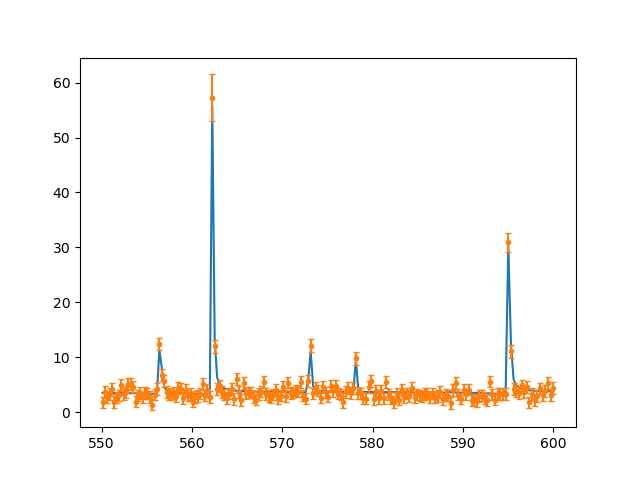

In [4]:
import ATARI.atari_io.hdf5 as io
from ATARI.utils.misc import fine_egrid 
from ATARI.utils.io.datacontainer import DataContainer
from ATARI.utils.io.pointwise import PointwiseContainer
from ATARI.utils.io.parameters import TheoreticalParameters, ExperimentalParameters


# read hdf
casenum = 2
theo_resladder = pd.read_hdf(case_file, f'sample_{casenum}/theo_par')
exp_pw, exp_cov = io.read_experimental(case_file, casenum)


threshold_0T = 1e-2
exp_par = ExperimentalParameters(0.067166, 0, threshold_0T)
theo_par = TheoreticalParameters(Ta_pair, theo_resladder)
est_par = TheoreticalParameters(Ta_pair, theo_resladder)

pwfine = pd.DataFrame({'E':fine_egrid(exp_pw.E,100)})
pw = PointwiseContainer(exp_pw, pwfine)
pw.add_experimental(exp_pw, exp_cov, exp_par)
pw.add_model(theo_par, exp_par, 'theo')


dc = DataContainer(pw, exp_par, theo_par)

figure()
# plot(pw.fine.E, pw.fine.theo_xs)
plot(dc.pw.exp.E, dc.pw.exp.theo_xs)
errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.')
# ylim([-max_xs*.1, max_xs*1.25])


## Class Setup

In [74]:
from dataclasses import dataclass
from typing import Optional

def get_resonance_ladder_from_feature_pairs(weights, feature_pairs):
    Elam = feature_pairs[:,0]
    Gt = feature_pairs[:,1]*1e3
    Gnx = Gt*weights
    Gg = Gt-Gnx
    resonances = np.array([Elam, Gt, Gnx, Gg, weights])
    resonance_ladder = pd.DataFrame(resonances.T, columns=['E', 'Gt', 'Gnx', 'Gg', 'w'])
    return resonance_ladder

@dataclass
class FeatureBank:
    feature_matrix: np.ndarray
    feature_pairs: np.ndarray
    potential_scattering: np.ndarray
    nfeatures: int
    solution_ws: Optional[np.ndarray] = None

    @property
    def model(self):
        return self.feature_matrix@self.solution_ws+self.potential_scattering
    def get_parameter_solution(self):
        return get_resonance_ladder_from_feature_pairs(self.solution_ws, self.feature_pairs)

@dataclass
class MatrixInputs:
    P: np.ndarray
    q: np.ndarray
    G: np.ndarray
    h: np.ndarray
    lb: np.ndarray
    ub: np.ndarray
    index_0T: np.ndarray
    


class Solvers:

    @staticmethod
    def solve_quadratic_program(inputs: MatrixInputs, solver="cvxopt",
                                                            verbose=False,
                                                            abstol=1e-12,
                                                            reltol=1e-12,
                                                            feastol= 1e-8,
                                                            maxiters = 100
                                                            )               -> Optional[np.ndarray] :
        sol_w = solve_qp(inputs.P, inputs.q, G=inputs.G, h=inputs.h, A=None, b=None, lb=inputs.lb, ub=inputs.ub, 
                                                                                                    solver=solver,
                                                                                                    verbose=verbose,
                                                                                                    abstol=abstol,
                                                                                                    reltol=reltol,
                                                                                                    feastol=feastol,
                                                                                                    maxiters=maxiters
                                                                                                    )
        if sol_w is None:
            sol_w = solve_qp(inputs.P, inputs.q, G=inputs.G, h=inputs.h, A=None, b=None, lb=inputs.lb, ub=inputs.ub, 
                                                                                                    solver=solver,
                                                                                                    verbose=verbose,
                                                                                                    abstol=1e-11,
                                                                                                    reltol=1e-11,
                                                                                                    feastol= 1e-7,
                                                                                                    maxiters=maxiters
                                                                                                    )
        if sol_w is None:
            _=0
        return sol_w
    
    @staticmethod
    def solve_linear_program(inputs):
        sol_w = linprog(inputs.q, A_ub=inputs.G, b_ub=inputs.h, bounds=np.array([inputs.lb, inputs.ub]).T)
        return sol_w.x
        

class ProblemHandler:

    def __init__(self, w_threshold):
        self.w_threshold = w_threshold
        

    def get_FeatureBank(self, dc: DataContainer, ElFeatures:np.ndarray, GtFeatures: np.ndarray):

        feature_matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(dc.pw.exp.E, dc.theo_par.particle_pair, ElFeatures, GtFeatures)
        nfeatures = np.shape(feature_matrix)[1]

        return FeatureBank(feature_matrix, feature_pairs, potential_scattering.flatten(), nfeatures)


    def get_MatrixInputs(self, dc: DataContainer, feature_bank: FeatureBank):
        P, q, G, h, lb, ub, index_0T =  fn.get_qp_inputs(np.array(dc.pw.exp.E), np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), 
                                                feature_bank.potential_scattering, dc.exp_par.max_xs, feature_bank.feature_matrix, feature_bank.feature_pairs, dc.theo_par.particle_pair)
        return MatrixInputs(P, q, G, h, lb, ub, index_0T)
    

    def get_ConstrainedMatrixInputs(self, dc:DataContainer, feature_bank: FeatureBank, w_constraint: float):
        P, q, G, h, lb, ub, index_0T =  fn.get_qp_inputs(np.array(dc.pw.exp.E), np.array(dc.pw.exp.exp_xs), np.array(dc.pw.CovXS), 
                                                feature_bank.potential_scattering, dc.exp_par.max_xs, feature_bank.feature_matrix, feature_bank.feature_pairs, dc.theo_par.particle_pair)
        G_wc = np.vstack([G,np.ones(len(P))])
        h_wc = np.append(h, w_constraint)
        return MatrixInputs(P, q, G_wc, h_wc, lb, ub, index_0T)


    def get_MinSolvableWeight(self, nfeatures: int, inputs: MatrixInputs):
        c = np.ones(nfeatures)
        lp_minw_unred = linprog(c, A_ub=inputs.G, b_ub=inputs.h, bounds=np.array([inputs.lb, inputs.ub]).T)
        return np.sum(lp_minw_unred.x)


    def reduce_FeatureBank(self, bank: FeatureBank, sol_w: np.ndarray):
        feature_matrix, feature_pairs, reduced_solw = fn.get_reduced_features(bank.feature_matrix, sol_w, self.w_threshold, bank.feature_pairs)
        nfeatures = np.shape(feature_matrix)[1]
        return FeatureBank(feature_matrix, feature_pairs, bank.potential_scattering, nfeatures), reduced_solw



## Approach

0. Solve initial and reduce feature bank (don't want to do this step but I am for now to speed up computation)

1. Solve unconstrained problem with 'full' feature bank. 

2. Run bisection routine to get solutions constrained to different number of features (Resonances)
    a. Maximum possible weight comes from 1.
    b. Solve for the minimum possible weight constraint using LP. 

3. For each solution corresponding to an integer number of features, reduce the feature bank and solve the unconstrained problem

4. For each solution from 3 as a prior, solve the GLLS problem to search the constinuous parameter space

5. Perform LRT between the models from 4

## Step 0, reduce initial feature bank for computational speed

In [6]:
### Step 0
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e0)
Gtot_features = np.round(np.array(theo_resladder.Gt),1)*1e-3

w_threshold = 1e-10
prob = ProblemHandler(w_threshold)

fb0 = prob.get_FeatureBank(dc, Elam_features, Gtot_features)
inp0 = prob.get_MatrixInputs(dc, fb0)

sol_lp0 = Solvers.solve_linear_program(inp0)

## Step 1, solve unconstrained problem

In [7]:
### Step 1
fb1, sol_lp0_reduced = prob.reduce_FeatureBank(fb0, sol_lp0)
inp1 = prob.get_MatrixInputs(dc, fb1)
sol_w1 = Solvers.solve_quadratic_program(inp1)

In [8]:
def solve_qp_w_constraint(dc, fb, wcon):
    inp = prob.get_ConstrainedMatrixInputs(dc, fb, wcon)
    sol = Solvers.solve_quadratic_program(inp)
    return sol, np.count_nonzero(sol>w_threshold)

## Step 2, run bisection routine

In [9]:
### Bisection Routine
def bisect(x0,x1):
    return (x0+x1)/2

def bisect_and_solve(current_target_ires, minval, maxval, target_numres, wcon, sol_ws, save_all, searching=True, termination_threshold=1e-3):

    icurrent_target_ires = current_target_ires-min(target_numres)
    
    while searching:

        # check termination criteria
        if abs((minval-maxval)/maxval) < termination_threshold:
            searching = False
        elif wcon[icurrent_target_ires] > 0:
            searching = False

        # bisect, solve, and save result
        new_w = bisect(minval, maxval)
        con_sol_ws, numres_sol = solve_qp_w_constraint(dc, fb1, new_w) # TODO: Make dc and fb dynamic here!
        ires_sol = numres_sol-min(target_numres)
        save_all.append((new_w, numres_sol))

        if numres_sol == current_target_ires:
            #record if current target
            if wcon[ires_sol] < new_w:
                wcon[ires_sol] = new_w
                sol_ws[:,ires_sol] = con_sol_ws

        elif numres_sol > current_target_ires:
            # record other if in target numres
            if numres_sol in target_numres:
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws
            # bisect again to find current target
            wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, minval, new_w, target_numres, wcon, sol_ws, save_all, searching=searching)

        elif numres_sol < current_target_ires:
            # record other if in target numres
            if numres_sol in target_numres:
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws
            # bisect again to find current target
            wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, wcon, sol_ws, save_all, searching=searching)

    return wcon, sol_ws, save_all, searching

def get_bounding_wcons(ires_target, save_all):
    temp = np.array(save_all)
    temp = temp[temp[:,0].argsort()]
    index = np.searchsorted(temp[:,1], ires_target, side='right')
    return temp[index-1,0], temp[index,0]

def get_target_numres_array(target_maxres, max_numres, min_numres):
    return np.arange(min_numres, np.min([target_maxres,max_numres])+1, 1)

def get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=None, sol_ws = None):
    if target_wcon is None and sol_ws is None:
        target_wcon = np.zeros(len(target_numres))
        if min_wcon == 0:
            min_wcon = 1e-10
        target_wcon[0] = min_wcon
        sol_ws = np.zeros((len(min_wcon_solw), len(target_numres)))
        sol_ws[:, 0] = min_wcon_solw
    elif target_wcon is None or sol_ws is None:
        raise ValueError("Either target_wcon or sol_ws is None while the other is populated, check input.")
    else:
        elements_to_add = len(target_numres)-len(target_wcon)
        assert elements_to_add >= 0, "target_numres is shorter than target_wcon"
        target_wcon = np.append(target_wcon, [0]*elements_to_add)
        sol_ws = np.append(sol_ws, np.zeros((np.shape(sol_ws)[0], elements_to_add)), axis=1)
    return target_wcon, sol_ws

In [10]:
### Step 2

# determine mins and maxes
min_wcon = prob.get_MinSolvableWeight(fb1.nfeatures, inp1)
max_wcon = np.sum(sol_w1)
max_numres = np.count_nonzero(sol_w1>w_threshold)
min_wcon_solw, min_numres = solve_qp_w_constraint(dc, fb1, min_wcon)

# determine targets
target_numres = get_target_numres_array(15, max_numres, min_numres)
target_wcon, target_sol_ws = get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=None, sol_ws=None)
save_all = [(min_wcon, min_numres), (max_wcon, max_numres)]

print(target_numres)
print(target_wcon)

# Run bisection routine
for current_target_ires in target_numres[::-1]:
    print(f'Found: {target_numres[target_wcon!=0]}')
    print(f'Current target: {current_target_ires}')
    minwcon, maxwcon = get_bounding_wcons(current_target_ires, save_all)
    target_wcon, target_sol_ws, save_all, _ = bisect_and_solve(current_target_ires,
                                                                minwcon, maxwcon,
                                                                target_numres, target_wcon, target_sol_ws, save_all)

print(target_numres)
print(target_wcon)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.e-10 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
Found: [0]
Current target: 15
Found: [ 0  6 13 15]
Current target: 14
Found: [ 0  6 13 14 15]
Current target: 13
Found: [ 0  6 13 14 15]
Current target: 12
Found: [ 0  6  9 12 13 14 15]
Current target: 11
Found: [ 0  6  9 11 12 13 14 15]
Current target: 10
Found: [ 0  6  9 10 11 12 13 14 15]
Current target: 9
Found: [ 0  6  9 10 11 12 13 14 15]
Current target: 8
Found: [ 0  6  7  8  9 10 11 12 13 14 15]
Current target: 7
Found: [ 0  6  7  8  9 10 11 12 13 14 15]
Current target: 6
Found: [ 0  6  7  8  9 10 11 12 13 14 15]
Current target: 5
Found: [ 0  4  5  6  7  8  9 10 11 12 13 14 15]
Current target: 4
Found: [ 0  4  5  6  7  8  9 10 11 12 13 14 15]
Current target: 3
Found: [ 0  3  4  5  6  7  8  9 10 11 12 13 14 15]
Current target: 2
Found: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Current target: 1
Found: [ 0  1  2 

## Step 3, Solve reduced, unconstrained solution for each integer number of resonances

In [80]:
integer_feature_solutions = {key: FeatureBank for key in target_numres[target_wcon!=0]}

chi2pairs = []

for numres in target_numres[target_wcon!=0]:
    
    inumres = numres-min(target_numres)

    # constrained unreduced
    constrained_solution = target_sol_ws[:, inumres]

    fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
    inp3 = prob.get_MatrixInputs(dc, fb3)
    fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

    integer_feature_solutions[numres] = fb3

    chi2 = chi2_val(fb3.model, dc.pw.exp.exp_xs, dc.pw.CovXS)
    chi2pairs.append((numres, chi2))


In [81]:
chi2pairs

[(0, 845.1589555283598),
 (1, 583.0564452341893),
 (2, 515.4073415245715),
 (3, 474.6383164884395),
 (4, 416.7410104628927),
 (5, 356.6618159575638),
 (6, 323.8790161187963),
 (7, 319.06496388474244),
 (8, 315.5982744011664),
 (9, 311.887088995618),
 (10, 307.0593067042933),
 (11, 303.53900971989356),
 (12, 299.17616790488813),
 (13, 143.63578228516818),
 (14, 141.07605567365835),
 (15, 131.3449446361892)]

## Step 4, run GLLS on transmission with reduced, unconstrained solution from 3 as prior

In [91]:
from ATARI.sammy_interface import sammy_functions, sammy_classes
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'transmission',
    solve_bayes = True,
    experimental_corrections = 'no_exp',
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = True,
    one_spingroup = True,
    energy_window = None 
    )

In [87]:
target_numres[target_wcon!=0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [88]:

for numres in target_numres[target_wcon!=0]:
    if numres == 0:
        continue
    ires_featurebank = integer_feature_solutions[numres]
    ires_resladder = ires_featurebank.get_parameter_solution()
    prior = fill_resonance_ladder(ires_resladder, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

    sammyINP = sammy_classes.SammyInputData(
        particle_pair = Ta_pair,
        resonance_ladder = prior, 
        experimental_data = dc.pw.exp, 
        experimental_cov = dc.pw.CovT, 
    )

    lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
    posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    est_par = TheoreticalParameters(Ta_pair, posterior)
    dc.add_estimate(est_par, label=numres)



In [89]:
print(dc.est_par.keys())
# dc.pw.exp

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


In [90]:
# for numres in target_numres[target_wcon!=0]:
numres = 4 

[ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.est_par.keys()]


[(16203.014392210283, 1),
 (16071.129837259634, 2),
 (16015.012611125243, 3),
 (16067.46861258541, 4),
 (13360.601397288901, 5),
 (15565.853053358389, 6),
 (14371.91378738745, 7),
 (7115.73081149604, 8),
 (15942.270817988878, 9),
 (12624.694771079685, 10),
 (12122.716843336042, 11),
 (14575.758557911038, 12),
 (142.14129364184396, 13),
 (139.5121506845766, 14),
 (128.45803450343905, 15)]

15942.270817988878
1.161265425992135
7115.73081149604
0.7197257864099826


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


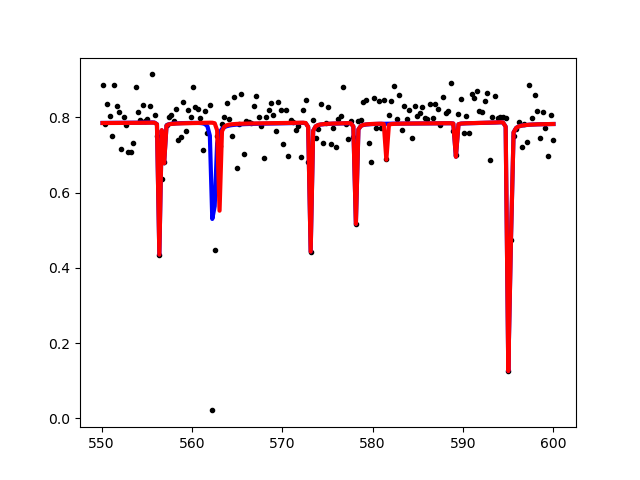

In [92]:
numres = 9

a = np.array(dc.pw.exp[f'{numres}_trans'])
b = np.array(dc.pw.exp.exp_trans)

a1 = np.array(dc.pw.exp[f'{numres-1}_trans'])

figure()
# plot(dc.pw.exp.E, dc.pw.exp.theo_trans, 'g')
plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.k')
plot(dc.pw.exp.E, dc.pw.exp[f'{numres-1}_trans'], 'b', lw=3)
plot(dc.pw.exp.E, dc.pw.exp[f'{numres}_trans'], 'r', lw=3)
# plot(dc.pw.exp.E, a)
# plot(dc.pw.exp.E, b,'.')

print(chi2_val(a, b, np.array(dc.pw.CovT)))
print(np.sum((a-b)**2))

print(chi2_val(a1, b, np.array(dc.pw.CovT)))
print(np.sum((a1-b)**2))





In [96]:
numres = 8
inumres = numres-min(target_numres)

# constrained unreduced
constrained_solution = target_sol_ws[:, inumres]

fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
inp3 = prob.get_MatrixInputs(dc, fb3)
fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

prior = fb3.get_parameter_solution()
prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = prior, 
    experimental_data = dc.pw.exp, 
    experimental_cov = dc.pw.CovT, 
)

lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
print(prior[['E','Gt','Gnx']])
print(posterior[['E','Gt','Gnx']])

15567.927507998511
7115.128776573061
            E    Gt       Gnx
0  556.393229  74.7  0.351238
1  556.893229  74.7  0.101894
2  562.493229  74.7  0.371524
3  573.093229  74.7  0.612783
4  578.093229  74.7  0.488884
5  589.193229  74.7  0.075101
6  594.993229  74.7  1.106615
7  595.293229  74.7  0.267640
            E          Gt       Gnx
0  556.399211   75.393193  0.375135
1  556.888734   74.976509  0.103639
2  562.356062  197.502717  1.450902
3  573.093666   75.267567  0.588071
4  578.093208   74.777804  0.476104
5  589.189935   74.770885  0.074802
6  594.994414   74.507892  1.080162
7  595.295060   75.047446  0.265003


In [97]:
numres = 9
inumres = numres-min(target_numres)

constrained_solution = target_sol_ws[:, inumres]

fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
inp3 = prob.get_MatrixInputs(dc, fb3)
fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

prior = fb3.get_parameter_solution()
prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = prior, 
    experimental_data = dc.pw.exp, 
    experimental_cov = dc.pw.CovT, 
)

lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
print(prior[['E','Gt','Gnx']])
print(posterior[['E','Gt','Gnx']])

15564.992580155233
15942.27113978467
            E    Gt       Gnx
0  556.393229  74.7  0.351687
1  556.893229  74.7  0.102424
2  562.493229  74.7  0.372024
3  573.093229  74.7  0.613568
4  578.093229  74.7  0.489575
5  581.493229  74.7  0.084125
6  589.193229  74.7  0.075538
7  594.993229  74.7  1.107081
8  595.293229  74.7  0.268048
            E         Gt       Gnx
0  556.396684  75.113677  0.357455
1  556.889276  74.877701  0.102543
2  562.982581  79.101450  0.670308
3  573.091997  75.143931  0.614229
4  578.092312  74.738615  0.487892
5  581.490923  74.696063  0.083941
6  589.189731  74.772286  0.075392
7  594.992251  74.600024  1.107090
8  595.295592  75.158920  0.266620


array([], shape=(0, 9), dtype=float64)

## Notes
hyperparameter: initial uncertainty on parameters?
should be large, we don't have a prior we just want the GLLS to converge.

fudge factor cant be too larger for numerics,
M' = (M^-1 + GtV^-1Gt)^-1
first term is full rank, second is not always. If M^-1 (1/var) is driven numerically to 0, the whole term won't be invertable
if NE>= NP then the second term will be full rank

could run sammy multiple times?

Test that chi2 on trans and xs converge to the same value in the limit of the linear regime (low variance)